In [1]:
import torch
from torchdiffeq import odeint, odeint_adjoint
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from models.odes.inf_bus.smib_o import synchronous_machine_ibo_torch
import time


Use pytorchdiff instead of scipy to solve the odes, synchronous_machine_ibo_torch function was used(different order of y and t from synchronous_machine_ibo)

In [2]:
# Define the Synchronous Machine model  
class SynchronousMachine(nn.Module):
    def __init__(self, D, P_m, theta0, omega_s0, omega_B, V, X_d_dash, H):
        super(SynchronousMachine, self).__init__()
        """
        Define a model with the selected parameters.

        Parameters:
        D: Damping coefficient
        P_m: Mechanical power input
        theta0: Initial electrical angle
        omega_s0: Initial synchronous speed
        omega_B: Base speed
        V: Terminal voltage
        X_d_dash: Transient reactance
        H: Inertia constant

        Returns:
        A model with the selected parameters.
        """
        self.D = D
        self.P_m = P_m
        self.theta0 = theta0
        self.omega_s0 = omega_s0
        self.omega_B = omega_B
        self.V = V
        self.X_d_dash = X_d_dash
        self.H = H


    def forward(self, t, y):
        """
        Define the differential equations for the Synchronous Machine model.
        """
        delta, omega, E_d_dash, E_q_dash = y
        # Calculate electrical power output
        P_e = (E_q_dash * self.V / self.X_d_dash) * torch.sin(delta - self.theta0)
        # Calculate acceleration
        ddelta_dt = (omega - self.omega_s0) * self.omega_B
        domega_dt = (1 / (2 * self.H)) * (self.P_m - P_e - self.D * (omega - self.omega_s0))
        dE_d_dash_dt = 0
        dE_q_dash_dt = 0
        result = torch.Tensor([ddelta_dt, domega_dt, dE_d_dash_dt, dE_q_dash_dt]).to(y.device)
        return result
    
# Initial conditions
y0 = torch.Tensor([np.pi*0.3, 0, 0, 1])
y0 = torch.tensor(y0).view(1,4).repeat(10,1)
# Time points
t = torch.linspace(0.0, 50.0, 1000)
# Parameters
D = 2
P_m = 0.1
theta0 = np.pi*0.5
omega_s0 = 0.0
omega_B = 2 * np.pi * 60
V = 1.0
X_d_dash = 1.0
H = 2.0
params=torch.Tensor([ D, P_m, theta0, omega_s0, omega_B, V, X_d_dash, H])


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#initiate time 

func = SynchronousMachine(D, P_m, theta0, omega_s0, omega_B, V, X_d_dash, H)
func_gpu= SynchronousMachine(D, P_m, theta0, omega_s0, omega_B, V, X_d_dash, H).to(device)

time1 = time.time()

def act_gpu(flag_gpu):
    if flag_gpu:
        return func_gpu
    else:
        return func

def act_adjoint(flag, func, y0, t):
    if flag:
        return odeint_adjoint(func, y0, t)
    else:
        return odeint(func, y0, t)


"""
def run(flag_gpu, flag_adjoint):
    if flag_adjoint:
        time0 = time.time()
        for j in range (5):
            result = act_adjoint(flag_gpu, act_gpu(flag_gpu), y0, t)
        time1 = time.time()
        return result,(time1-time0)
    else:
        time0 = time.time()
        for j in range (5):
            result = act_adjoint(flag_gpu, act_gpu(flag_gpu), y0, t)
        time1 = time.time()
        return result,(time1-time0)
    
result0, time0 = run(True, True) # GPU and adjoint
result1, time1 = run(True, False) # GPU and no adjoint
result2, time2 = run(False, True) # no GPU and adjoint
result3, time3 = run(False, False) # no GPU and no adjoint
print("time0", time0, "time1", time1, "time2", time2, "time3", time3)


plt.plot(t, result0[:, 0], label='x(t)')
plt.show()
plt.plot(t, result0[:, 1], label='x(t)')
plt.show()
"""


cuda


C:\Users\Giannis\AppData\Local\Temp\ipykernel_31336\161095245.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y0 = torch.tensor(y0).view(1,4).repeat(10,1)


'\ndef run(flag_gpu, flag_adjoint):\n    if flag_adjoint:\n        time0 = time.time()\n        for j in range (5):\n            result = act_adjoint(flag_gpu, act_gpu(flag_gpu), y0, t)\n        time1 = time.time()\n        return result,(time1-time0)\n    else:\n        time0 = time.time()\n        for j in range (5):\n            result = act_adjoint(flag_gpu, act_gpu(flag_gpu), y0, t)\n        time1 = time.time()\n        return result,(time1-time0)\n    \nresult0, time0 = run(True, True) # GPU and adjoint\nresult1, time1 = run(True, False) # GPU and no adjoint\nresult2, time2 = run(False, True) # no GPU and adjoint\nresult3, time3 = run(False, False) # no GPU and no adjoint\nprint("time0", time0, "time1", time1, "time2", time2, "time3", time3)\n\n\nplt.plot(t, result0[:, 0], label=\'x(t)\')\nplt.show()\nplt.plot(t, result0[:, 1], label=\'x(t)\')\nplt.show()\n'

Tried to parallelise it

In [3]:
class NeuralODETorch(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.func = SynchronousMachine(D, P_m, theta0, omega_s0, omega_B, V, X_d_dash, H).to(device)
        self.multiple = multiple
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(self.device)

    def forward(self, y0, t1):
        if self.multiple:
            t = torch.linspace(0, t1, 100).to(self.device)
            func=self.func
            y = torch.zeros((y0.shape[0], t.shape[0], y0.shape[1])).to(self.device)
            for i in range(y0.shape[0]):
                y[i] = odeint_adjoint(func, y0[i], t)
        else:
            t = torch.tensor([0.0, t1]).to(self.device)
            y = odeint_adjoint(self.func, y0, t)
        return y

model = NeuralODETorch(multiple=True)

# Use DataParallel to run multiple batches of y0 in parallel
model = torch.nn.DataParallel(model)
model.to(device)
y0 = [np.pi*0.3, 0, 0, 1]
y0 = torch.tensor(y0).to(device)
y0 = torch.tensor(y0).view(1,4).repeat(10,1).to(device)

# Enable cudnn.benchmark for improved performance
torch.backends.cudnn.benchmark = True

# Run the model on GPU
y = model(y0, 50)


cuda


C:\Users\Giannis\AppData\Local\Temp\ipykernel_31336\3105800966.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y0 = torch.tensor(y0).view(1,4).repeat(10,1).to(device)


ValueError: x and y must have same first dimension, but have shapes (1000,) and (100,)

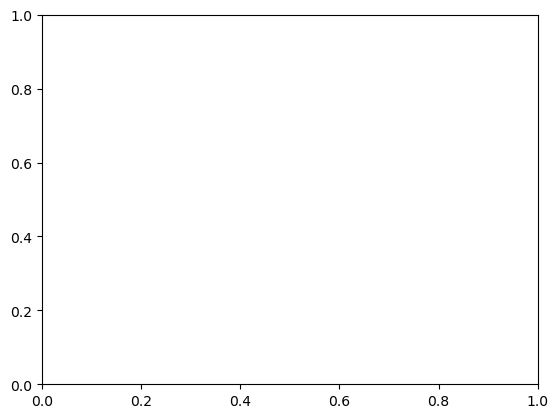

In [4]:
for i in range(10):
    plt.plot(t.cpu().numpy(), y[i, :, 0].cpu().numpy().T)
plt.show()
for i in range(10):
    plt.plot(t.cpu().numpy(), y[i, :, 1].cpu().numpy().T)
plt.show()


In [11]:
result0 = act_adjoint(True, act_gpu(True), y0, t)


c:\Users\Giannis\anaconda30\Lib\site-packages\torchdiffeq\_impl\misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


ValueError: too many values to unpack (expected 4)

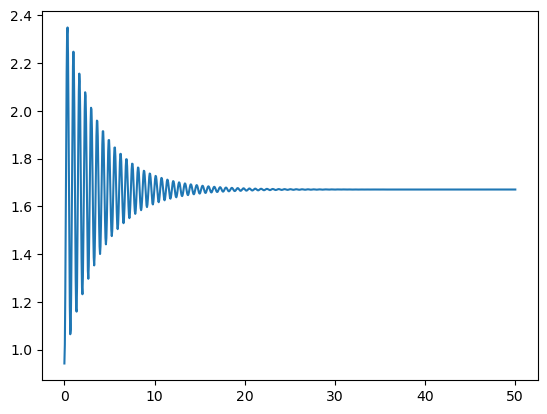

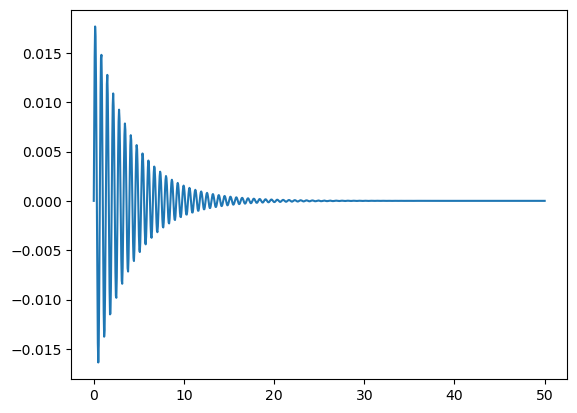

In [ ]:
plt.plot(t, result0[:, 0], label='x(t)')
plt.show()
plt.plot(t, result0[:, 1], label='x(t)')
plt.show()

In [ ]:
# Initial conditions
y0 = [np.pi*0.3, 0, 0, 1]

# Time points
t = np.linspace(0, 10, 1000)

# Parameters
D = 2
P_m = 0.1
theta0 = np.pi*0.5
omega_s0 = 0.0
omega_B = 2 * np.pi * 60
V = 1.0
X_d_dash = 1.0
H = 2.0
y0 = y0+[ D, P_m, theta0, omega_s0, omega_B, V, X_d_dash, H]

y0 = torch.tensor(y0)
t = torch.tensor(t)
# Solve the ODE
solution = odeint(synchronous_machine_ibo_torch, y0, t)

# Extract the delta and omega values
delta = solution[:, 0]
omega = solution[:, 1]

# Plot the solution
plt.plot(t, delta, label='delta(t)')
plt.plot(t, omega, label='omega(t)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Extract the x and v speeds
x_speeds = solution[:, 0]
v_speeds = solution[:, 1]

# Plot the solution

plt.plot(t, x_speeds, label='x(t)')
plt.plot(t, v_speeds, label='v(t)')


NameError: name 'np' is not defined

Gradient check passed.


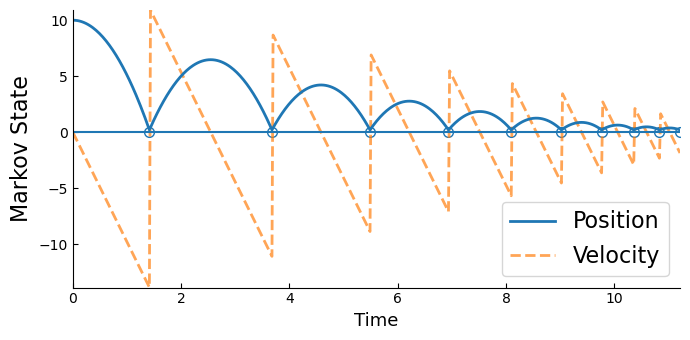

In [2]:
#!/usr/bin/env python3
import argparse
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchdiffeq import odeint, odeint_adjoint
from torchdiffeq import odeint_event

torch.set_default_dtype(torch.float64)


class BouncingBallExample(nn.Module):
    """
    A class representing a bouncing ball example.

    Parameters:
    - radius (float): The radius of the ball. Default is 0.2.
    - gravity (float): The acceleration due to gravity. Default is 9.8.
    - adjoint (bool): Whether to use adjoint method for solving ODEs. Default is False.

    Methods:
    - forward(t, state): Computes the derivatives of the state variables at a given time.
    - event_fn(t, state): Determines if a collision event occurs at a given time and state.
    - get_initial_state(): Returns the initial time and state of the ball.
    - state_update(state): Updates the state of the ball after a collision event.
    - get_collision_times(nbounces): Computes the times at which collision events occur.
    - simulate(nbounces): Simulates the motion of the ball and returns the trajectory, velocity, and event times.
    """

    def __init__(self, radius=0.2, gravity=9.8, adjoint=False):
        super().__init__()
        self.gravity = nn.Parameter(torch.as_tensor([gravity]))
        self.log_radius = nn.Parameter(torch.log(torch.as_tensor([radius])))
        self.t0 = nn.Parameter(torch.tensor([0.0]))
        self.init_pos = nn.Parameter(torch.tensor([10.0]))
        self.init_vel = nn.Parameter(torch.tensor([0.0]))
        self.absorption = nn.Parameter(torch.tensor([0.2]))
        self.odeint = odeint_adjoint if adjoint else odeint

    def forward(self, t, state):
        """
        Computes the derivatives of the state variables at a given time.

        Parameters:
        - t (torch.Tensor): The time at which to compute the derivatives.
        - state (tuple): The current state of the ball, consisting of position, velocity, and log radius.

        Returns:
        - tuple: The derivatives of the state variables (position, velocity, and log radius).
        """
        pos, vel, log_radius = state
        dpos = vel
        dvel = -self.gravity
        return dpos, dvel, torch.zeros_like(log_radius)

    def event_fn(self, t, state):
        """
        Determines if a collision event occurs at a given time and state.

        Parameters:
        - t (torch.Tensor): The time at which to check for a collision event.
        - state (tuple): The current state of the ball, consisting of position, velocity, and log radius.

        Returns:
        - torch.Tensor: A tensor indicating if a collision event occurs (positive if ball in mid-air, negative if ball within ground).
        """
        pos, _, log_radius = state
        return pos - torch.exp(log_radius)

    def get_initial_state(self):
        """
        Returns the initial time and state of the ball.

        Returns:
        - tuple: The initial time and state of the ball.
        """
        state = (self.init_pos, self.init_vel, self.log_radius)
        return self.t0, state

    def state_update(self, state):
        """
        Updates the state of the ball after a collision event.

        Parameters:
        - state (tuple): The current state of the ball, consisting of position, velocity, and log radius.

        Returns:
        - tuple: The updated state of the ball.
        """
        pos, vel, log_radius = state
        pos = pos + 1e-7  # need to add a small eps so as not to trigger the event function immediately.
        vel = -vel * (1 - self.absorption)
        return (pos, vel, log_radius)

    def get_collision_times(self, nbounces=1):
        """
        Computes the times at which collision events occur.

        Parameters:
        - nbounces (int): The number of bounces to consider. Default is 1.

        Returns:
        - list: A list of tensors representing the times at which collision events occur.
        """
        event_times = []

        t0, state = self.get_initial_state()

        for i in range(nbounces):
            event_t, solution = odeint_event(
                self,
                state,
                t0,
                event_fn=self.event_fn,
                reverse_time=False,
                atol=1e-8,
                rtol=1e-8,
                odeint_interface=self.odeint,
            )
            event_times.append(event_t)

            state = self.state_update(tuple(s[-1] for s in solution))
            t0 = event_t

        return event_times

    def simulate(self, nbounces=1):
        """
        Simulates the motion of the ball and returns the trajectory, velocity, and event times.

        Parameters:
        - nbounces (int): The number of bounces to simulate. Default is 1.

        Returns:
        - tuple: A tuple containing the times, trajectory, velocity, and event times of the ball.
        """
        event_times = self.get_collision_times(nbounces)

        # get dense path
        t0, state = self.get_initial_state()
        trajectory = [state[0][None]]
        velocity = [state[1][None]]
        times = [t0.reshape(-1)]
        for event_t in event_times:
            tt = torch.linspace(
                float(t0), float(event_t), int((float(event_t) - float(t0)) * 50)
            )[1:-1]
            tt = torch.cat([t0.reshape(-1), tt, event_t.reshape(-1)])
            solution = odeint(self, state, tt, atol=1e-8, rtol=1e-8)

            trajectory.append(solution[0][1:])
            velocity.append(solution[1][1:])
            times.append(tt[1:])

            state = self.state_update(tuple(s[-1] for s in solution))
            t0 = event_t

        return (
            torch.cat(times),
            torch.cat(trajectory, dim=0).reshape(-1),
            torch.cat(velocity, dim=0).reshape(-1),
            event_times,
        )


def gradcheck(nbounces):

    system = BouncingBallExample()

    variables = {
        "init_pos": system.init_pos,
        "init_vel": system.init_vel,
        "t0": system.t0,
        "gravity": system.gravity,
        "log_radius": system.log_radius,
    }

    event_t = system.get_collision_times(nbounces)[-1]
    event_t.backward()

    analytical_grads = {}
    for name, p in system.named_parameters():
        for var in variables.keys():
            if var in name:
                analytical_grads[var] = p.grad

    eps = 1e-3

    fd_grads = {}

    for var, param in variables.items():
        orig = param.data
        param.data = orig - eps
        f_meps = system.get_collision_times(nbounces)[-1]
        param.data = orig + eps
        f_peps = system.get_collision_times(nbounces)[-1]
        param.data = orig
        fd = (f_peps - f_meps) / (2 * eps)
        fd_grads[var] = fd

    success = True
    for var in variables.keys():
        analytical = analytical_grads[var]
        fd = fd_grads[var]
        if torch.norm(analytical - fd) > 1e-4:
            success = False
            print(
                f"Got analytical grad {analytical.item()} for {var} param but finite difference is {fd.item()}"
            )

    if not success:
        raise Exception("Gradient check failed.")

    print("Gradient check passed.")


if __name__ == "__main__":

    parser = argparse.ArgumentParser(description="Process some integers.")
    parser.add_argument("nbounces", type=int, nargs="?", default=10)
    parser.add_argument("--adjoint", action="store_true")
    args, unknown = parser.parse_known_args()


    gradcheck(args.nbounces)

    system = BouncingBallExample()
    times, trajectory, velocity, event_times = system.simulate(nbounces=args.nbounces)
    times = times.detach().cpu().numpy()
    trajectory = trajectory.detach().cpu().numpy()
    velocity = velocity.detach().cpu().numpy()
    event_times = torch.stack(event_times).detach().cpu().numpy()

    plt.figure(figsize=(7, 3.5))

    # Event locations.
    for event_t in event_times:
        plt.plot(
            event_t,
            0.0,
            color="C0",
            marker="o",
            markersize=7,
            fillstyle="none",
            linestyle="",
        )

    (vel,) = plt.plot(
        times, velocity, color="C1", alpha=0.7, linestyle="--", linewidth=2.0
    )
    (pos,) = plt.plot(times, trajectory, color="C0", linewidth=2.0)

    plt.hlines(0, 0, 100)
    plt.xlim([times[0], times[-1]])
    plt.ylim([velocity.min() - 0.02, velocity.max() + 0.02])
    plt.ylabel("Markov State", fontsize=16)
    plt.xlabel("Time", fontsize=13)
    plt.legend([pos, vel], ["Position", "Velocity"], fontsize=16)

    plt.gca().xaxis.set_tick_params(
        direction="in", which="both"
    )  # The bottom will maintain the default of 'out'
    plt.gca().yaxis.set_tick_params(
        direction="in", which="both"
    )  # The bottom will maintain the default of 'out'

    # Hide the right and top spines
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)

    # Only show ticks on the left and bottom spines
    plt.gca().yaxis.set_ticks_position("left")
    plt.gca().xaxis.set_ticks_position("bottom")

    plt.tight_layout()
    plt.savefig("bouncing_ball.png")

In [6]:
#!/usr/bin/env python3

import argparse
import os
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchdiffeq import odeint, odeint_event



class HamiltonianDynamics(nn.Module):
    def __init__(self):
        super().__init__()
        self.dvel = nn.Linear(1, 1)
        self.scale = nn.Parameter(torch.tensor(10.0))

    def forward(self, t, state):
        pos, vel, *rest = state
        dpos = vel
        dvel = torch.tanh(self.dvel(torch.zeros_like(vel))) * self.scale
        return (dpos, dvel, *[torch.zeros_like(r) for r in rest])


class EventFn(nn.Module):
    def __init__(self):
        super().__init__()
        self.radius = nn.Parameter(torch.rand(1))

    def parameters(self):
        return [self.radius]

    def forward(self, t, state):
        # IMPORTANT: event computation must use variables from the state.
        pos, _, radius = state
        return pos - radius.reshape_as(pos) ** 2


class InstantaneousStateChange(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Linear(1, 1)

    def forward(self, t, state):
        pos, vel, *rest = state
        vel = -torch.sigmoid(self.net(torch.ones_like(vel))) * vel
        return (pos, vel, *rest)


class NeuralPhysics(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial_pos = nn.Parameter(torch.tensor([10.0]))
        self.initial_vel = nn.Parameter(torch.tensor([0.0]))
        self.dynamics_fn = HamiltonianDynamics()
        self.event_fn = EventFn()
        self.inst_update = InstantaneousStateChange()

    def simulate(self, times):

        t0 = torch.tensor([0.0]).to(times)

        # Add a terminal time to the event function.
        def event_fn(t, state):
            if t > times[-1] + 1e-7:
                return torch.zeros_like(t)
            event_fval = self.event_fn(t, state)
            return event_fval

        # IMPORTANT: for gradients of odeint_event to be computed, parameters of the event function
        # must appear in the state in the current implementation.
        state = (self.initial_pos, self.initial_vel, *self.event_fn.parameters())

        event_times = []

        trajectory = [state[0][None]]

        n_events = 0
        max_events = 20

        while t0 < times[-1] and n_events < max_events:
            last = n_events == max_events - 1

            if not last:
                event_t, solution = odeint_event(
                    self.dynamics_fn,
                    state,
                    t0,
                    event_fn=event_fn,
                    atol=1e-8,
                    rtol=1e-8,
                    method="dopri5",
                )
            else:
                event_t = times[-1]

            interval_ts = times[times > t0]
            interval_ts = interval_ts[interval_ts <= event_t]
            interval_ts = torch.cat([t0.reshape(-1), interval_ts.reshape(-1)])

            solution_ = odeint(
                self.dynamics_fn, state, interval_ts, atol=1e-8, rtol=1e-8
            )
            traj_ = solution_[0][1:]  # [0] for position; [1:] to remove intial state.
            trajectory.append(traj_)

            if event_t < times[-1]:
                state = tuple(s[-1] for s in solution)

                # update velocity instantaneously.
                state = self.inst_update(event_t, state)

                # advance the position a little bit to avoid re-triggering the event fn.
                pos, *rest = state
                pos = pos + 1e-7 * self.dynamics_fn(event_t, state)[0]
                state = pos, *rest

            event_times.append(event_t)
            t0 = event_t

            n_events += 1

            # print(event_t.item(), state[0].item(), state[1].item(), self.event_fn.mod(pos).item())

        trajectory = torch.cat(trajectory, dim=0).reshape(-1)
        return trajectory, event_times


class Sine(nn.Module):
    def forward(self, x):
        return torch.sin(x)


class NeuralODE(nn.Module):
    def __init__(self, aug_dim=2):
        super().__init__()
        self.initial_pos = nn.Parameter(torch.tensor([10.0]))
        self.initial_aug = nn.Parameter(torch.zeros(aug_dim))
        self.odefunc = mlp(
            input_dim=1 + aug_dim,
            hidden_dim=64,
            output_dim=1 + aug_dim,
            hidden_depth=2,
            act=Sine,
        )

        def init(m):
            if isinstance(m, nn.Linear):
                std = 1.0 / math.sqrt(m.weight.size(1))
                m.weight.data.uniform_(-2.0 * std, 2.0 * std)
                m.bias.data.zero_()

        self.odefunc.apply(init)

    def forward(self, t, state):
        return self.odefunc(state)

    def simulate(self, times):
        x0 = torch.cat([self.initial_pos, self.initial_aug]).reshape(-1)
        solution = odeint(self, x0, times, atol=1e-8, rtol=1e-8, method="dopri5")
        trajectory = solution[:, 0]
        return trajectory, []


def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None, act=nn.ReLU):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), act()]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), act()]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk


def cosine_decay(learning_rate, global_step, decay_steps, alpha=0.0):
    global_step = min(global_step, decay_steps)
    cosine_decay = 0.5 * (1 + math.cos(math.pi * global_step / decay_steps))
    decayed = (1 - alpha) * cosine_decay + alpha
    return learning_rate * decayed


def learning_rate_schedule(
    global_step, warmup_steps, base_learning_rate, lr_scaling, train_steps
):
    warmup_steps = int(round(warmup_steps))
    scaled_lr = base_learning_rate * lr_scaling
    if warmup_steps:
        learning_rate = global_step / warmup_steps * scaled_lr
    else:
        learning_rate = scaled_lr

    if global_step < warmup_steps:
        learning_rate = learning_rate
    else:
        learning_rate = cosine_decay(
            scaled_lr, global_step - warmup_steps, train_steps - warmup_steps
        )
    return learning_rate


def set_learning_rate(optimizer, lr):
    for group in optimizer.param_groups:
        group["lr"] = lr


if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument("--base_lr", type=float, default=0.1)
    parser.add_argument("--num_iterations", type=int, default=1000)
    parser.add_argument("--no_events", action="store_true")
    parser.add_argument("--save", type=str, default="figs")
    args, unknown = parser.parse_known_args()

    torch.manual_seed(0)

    torch.set_default_dtype(torch.float64)

    with torch.no_grad():
        system = BouncingBallExample()
        obs_times, gt_trajectory, _, _ = system.simulate(nbounces=4)

    obs_times = obs_times[:300]
    gt_trajectory = gt_trajectory[:300]

    if args.no_events:
        model = NeuralODE()
    else:
        model = NeuralPhysics()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.base_lr)

    decay = 1.0

    model.train()
    for itr in range(args.num_iterations):
        optimizer.zero_grad()
        trajectory, event_times = model.simulate(obs_times)
        weights = decay**obs_times
        loss = (
            ((trajectory - gt_trajectory) / (gt_trajectory + 1e-3))
            .abs()
            .mul(weights)
            .mean()
        )
        loss.backward()

        lr = learning_rate_schedule(itr, 0, args.base_lr, 1.0, args.num_iterations)
        set_learning_rate(optimizer, lr)
        optimizer.step()

        if itr % 10 == 0:
            print(itr, loss.item(), len(event_times))

        if itr % 10 == 0:
            plt.figure()
            plt.plot(
                obs_times.detach().cpu().numpy(),
                gt_trajectory.detach().cpu().numpy(),
                label="Target",
            )
            plt.plot(
                obs_times.detach().cpu().numpy(),
                trajectory.detach().cpu().numpy(),
                label="Learned",
            )
            plt.tight_layout()
            os.makedirs(args.save, exist_ok=True)
            plt.savefig(f"{args.save}/{itr:05d}.png")
            plt.close()

        if (itr + 1) % 100 == 0:
            torch.save(
                {
                    "state_dict": model.state_dict(),
                },
                f"{args.save}/model.pt",
            )

        del trajectory, loss

0 17.726109061363356 1
10 0.8444178287973312 4
20 0.5233278357452423 5
30 0.2965804569308167 4
40 0.2734410190629645 4
50 0.2355387422341694 4
60 0.22042831891375328 4
70 0.20404002910226898 4
80 0.1887377214310934 4
90 0.17287509961913541 4
100 0.15613116292284385 4
110 0.13656688767078795 4
120 0.11832496159543415 4
130 0.10395576853538285 4
140 0.08234298423492431 4
150 0.06500481209427911 4
160 0.046232628806351615 4
170 0.08642698638823669 4
180 0.07863931632208102 4
190 0.10090333999830042 4
200 0.053370149963156546 4
210 0.06936536522566887 4
220 0.07704559829374223 4
230 0.1626946940127872 4
240 0.05915294592062937 4
250 0.016683247417413113 4
260 0.09066531369504383 4
270 0.049407657431735315 4
280 0.046901255404657775 4
290 0.008819083546684474 4
300 0.04657982248983241 4
310 0.1504929540491415 4
320 0.07505917049960144 4
330 0.02202645465752748 4
340 0.019265772041357997 4
350 0.047666757826741984 4
360 0.11911615962328352 4
370 0.047277347830316105 4
380 0.03453154284941894